# Predicción de cáncer de próstata

#### Datos

Consideramos un estudio médico realizado en 97 hombres con cáncer de próstata.
El enfoque está en la relación entre el antígeno prostático específico (psa), que está elevado en hombres con cáncer de próstata, y otras medidas clínicas. 
Las otras medidas clínicas son las variables predictoras, recopiladas en un examen médico, y la cantidad de expresión del antígeno asociado con la detección del cáncer es la variable de respuesta (lpsa).

Por lo tanto, el marco de datos está compuesto por 97 observaciones sobre 9 variables:
* lcavol: logaritmo del volumen del cáncer
* lweight: logaritmo del peso de la próstata
* age: edad del paciente en años
* lbph: logaritmo de la cantidad de hiperplasia prostática benigna
* svi: invasión de vesícula seminal
* lcp: logaritmo de la penetración capsular
* gleason: puntuación de Gleason
* pgg45: porcentaje de puntuación de Gleason 4 o 5
* lpsa: logaritmo del antígeno prostático específico

El objetivo es encontrar modelos que predigan la respuesta lpsa.

#### Modelos

Los datos están representados por $n$ puntos en $p$ dimensiones, por lo tanto la variable predictora se escribe $X\in\mathbb{R}^{n\times p}$ y la variable de respuesta es $y\in\mathbb{R}^n$.

En este trabajo, estamos interesados en la relación entre el predictor $X$ y la respuesta $y$.
Para determinar esta relación, adoptamos modelos de regresión.
La línea base estándar se logra con regresión lineal y comparamos resultados para regresiones regularizadas: **Regresión Ridge**, **Lasso** y **Elastic Net**.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns

## Exploración de datos

In [2]:
# Carga el dataset desde un archivo de texto separado por tabuladores
lpsa_data = pd.read_csv('data/prostate_dataset.txt', delimiter='\t')

# Selecciona todas las columnas a partir de 'lcavol' hasta el final del dataset
lpsa_data = lpsa_data.loc[:, 'lcavol':]

# Muestra las primeras 5 filas del dataset resultante
lpsa_data.head()


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


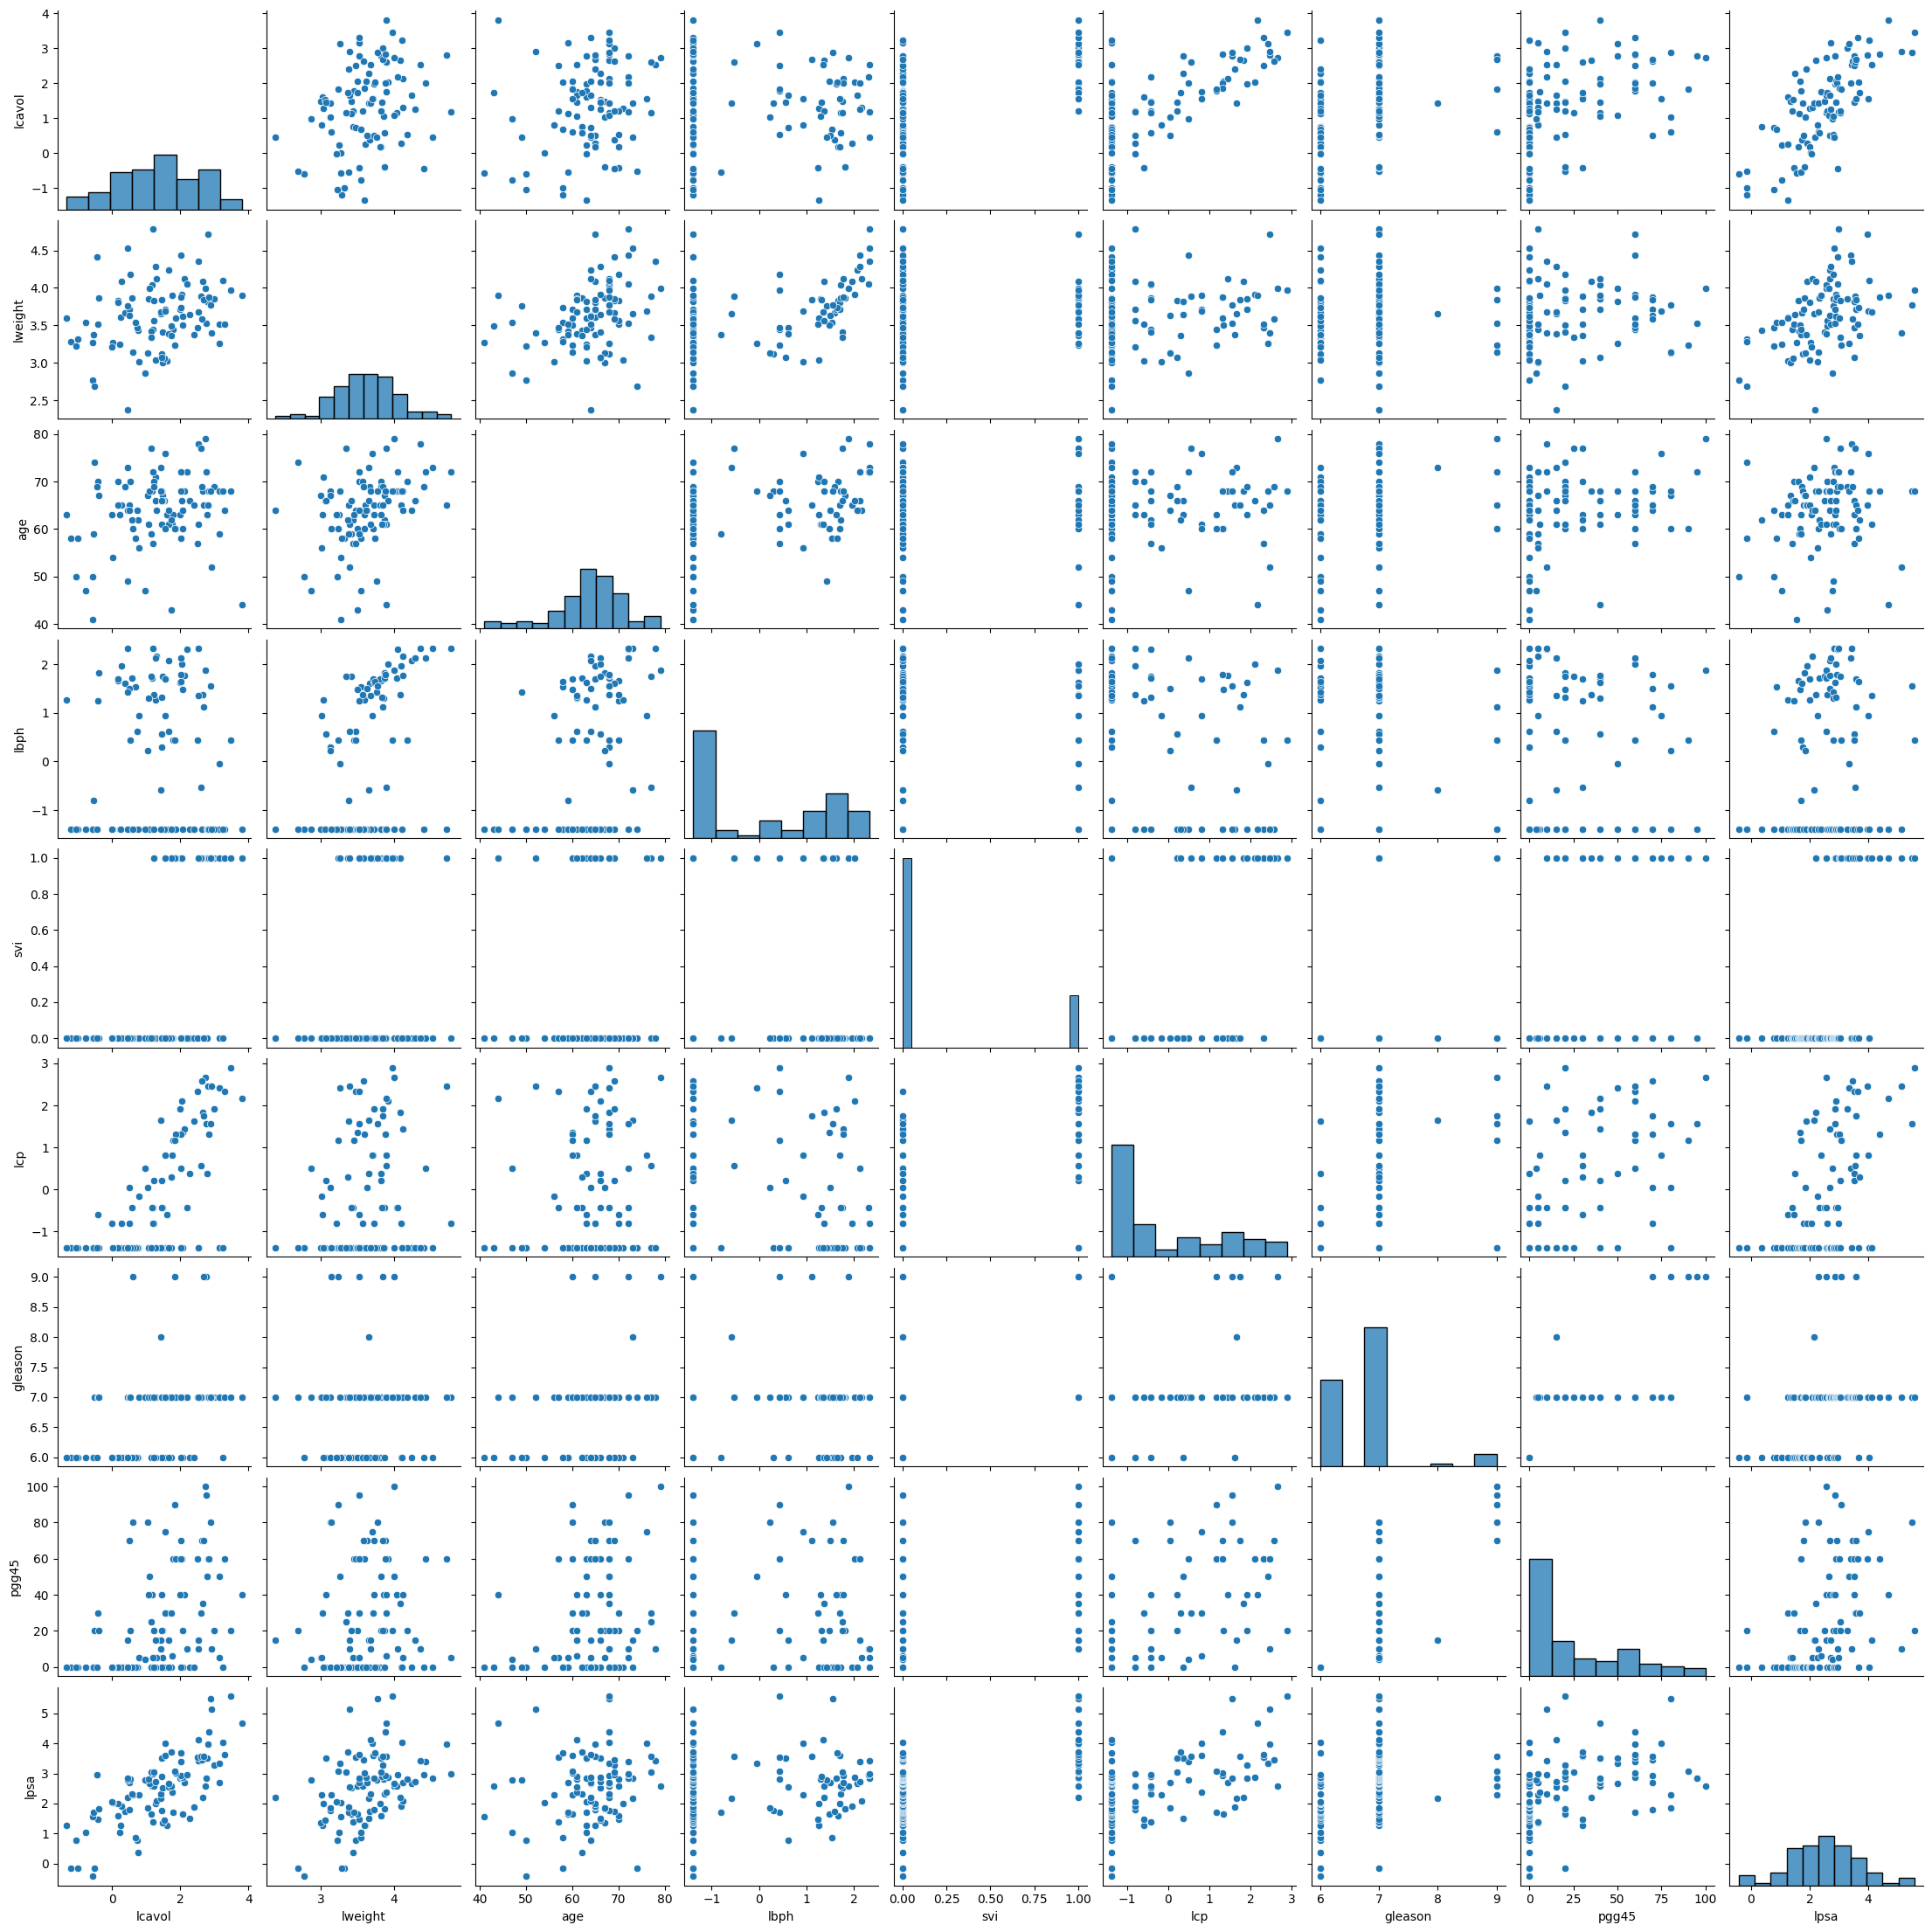

In [3]:
sns.pairplot(lpsa_data);

* lpsa está casi distribuido normalmente.
* la presencia de svi es binaria
* lcp: debido a mediciones no apropiadas, para valores pequeños de penetración capsular, se ha establecido arbitrariamente en -1.25.
* gleason y pgg45 no parecen estar correlacionados...

Veamos la correlación entre las variables.

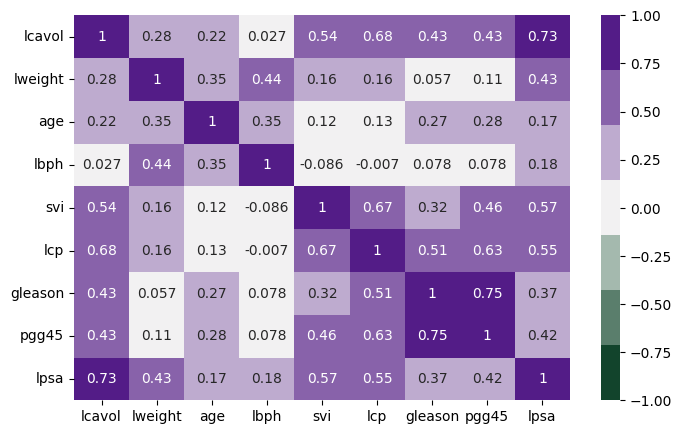

In [4]:
#### CODE
# sns.diverging_palette(145, 280, s=85, l=25, n=7)
plt.figure(figsize=(8,5))
sns.heatmap(lpsa_data.corr(),
           vmin=-1,
           vmax=1,
           cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True);

* La variable más correlacionada con la respuesta lpsa es lcavol.
  Por lo tanto, en un análisis de datos, la variable lcavol debe incluirse como predictor.

* La matriz de correlación muestra que gleason y pgg45 están efectivamente correlacionadas. 
  De hecho, la variable pgg45 mide el porcentaje de puntuaciones de Gleason 4 o 5 que se registraron antes de la puntuación actual final de Gleason.

Grafiquemos la relación entre la respuesta lpsa y la característica lcavol.

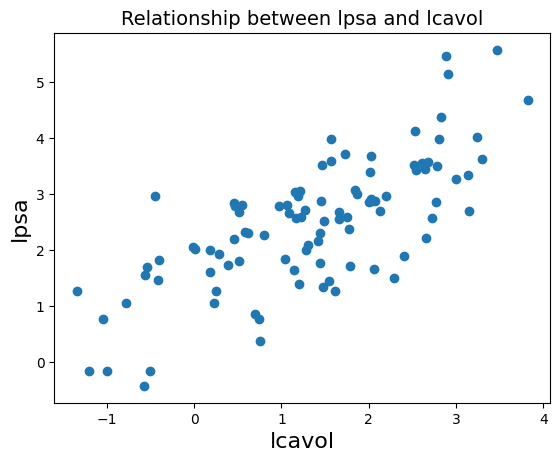

In [5]:
plt.scatter(lpsa_data['lcavol'], lpsa_data['lpsa'])
plt.xlabel('lcavol', fontsize=16)
plt.ylabel('lpsa', fontsize=16)
plt.title("Relationship between lpsa and lcavol", fontsize=14)
plt.show()

Hay una relación lineal bastante clara con correlación positiva, como se ve en la matriz de correlación.

### División de datos entrenamiento/prueba

In [6]:
# train : the first rows 
# test : the last rows 
n_split = 60

# Selecciona las primeras 60 filas como datos de entrenamiento (todas las columnas menos las dos últimas → se excluye 'pgg45')
X_train = lpsa_data.iloc[:n_split, 0:-2]

# Selecciona el resto de filas como datos de prueba (mismas columnas que en entrenamiento)
X_test = lpsa_data.iloc[n_split:, 0:-2]

# Selecciona la columna 'lpsa' (última del dataset) como variable objetivo en entrenamiento
y_train = lpsa_data.iloc[:n_split, -1]

# Selecciona la columna 'lpsa' para el conjunto de prueba
y_test = lpsa_data.iloc[n_split:, -1]


In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60, 7)
(37, 7)
(60,)
(37,)


# Modelos de aprendizaje

# 1) Baseline de regresión lineal

La regresión lineal intenta modelar la relación entre las variables predictoras $X$ y la variable de respuesta $y$.
Consiste en encontrar una función lineal $f:\mathbb{R}^p \to \mathbb{R}$ que prediga la respuesta $y_i$ a partir de los predictores $X_{i1},...,X_{ip}$ dadas $n$ observaciones para $i=1,...,n$.

En Python, la regresión lineal está implementada como [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) en el módulo linear_model de scikit-learn.

In [8]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))
print("Test R2:", metrics.r2_score(y_test, lr.predict(X_test)))

Train MSE: 0.2877748864599949
Test MSE: 2.864149965701442
Test RMSE: 1.6923799708403082
Test R2: -4.642928683864814


### Interpretación
1. **Train MSE (0.288) vs Test MSE (2.864)**  
   - En entrenamiento el error es bajo.  
   - En prueba el error es casi **10 veces mayor** → hay un **claro sobreajuste** (el modelo aprendió demasiado los datos de train y no generaliza).  

2. **Test RMSE (1.692)**  
   - Significa que, en promedio, las predicciones se equivocan por ~1.7 unidades en la escala de `lpsa`.  
   - Para este dataset, ese error es bastante grande.  

3. **Test R² (-4.64)**  
   - Un valor negativo implica que el modelo predice **peor que si simplemente tomaras la media de `y_test` como predicción constante**.  
   - Esto es una fuerte señal de que el modelo no está funcionando bien.  

###  Conclusión
Sí, estos números son **malos**. Tu modelo **se ajusta demasiado al train** y **fracasa en test**.  


# 2) Regularización

Para evitar el sobreaprendizaje, el método de regularización permite controlar la complejidad del modelo.
El modelo minimiza el error más un término de regularización $\lambda Reg(\beta)$ que mide la complejidad, donde $Reg(\beta)$ es un término de penalización y $\lambda$ es un hiperparámetro.
El hiperparámetro controla la influencia relativa del término de error y la cantidad de regularización.
El valor óptimo de $\lambda$ se puede encontrar mediante validación cruzada (ver repositorio [cross-validation](https://github.com/christelle-git/cross-validation/)). 

## 2.1) Regresión Ridge 

En la regresión Ridge, el término de regularización es $Reg(\beta) = ||\beta||_2^2$.
La regresión Ridge permite reducir la magnitud de los pesos $\beta_i$ de la regresión lineal, y así evitar el sobreaprendizaje.
La regresión Ridge tiene un efecto de selección agrupada: las variables correlacionadas tienen los mismos pesos.

In [9]:
from sklearn.linear_model import Ridge

# Crea un modelo de regresión Ridge con alpha=10 (regularización L2)
ridgeR = Ridge(alpha=10)

# Ajusta el modelo con los datos de entrenamiento
ridgeR.fit(X_train, y_train)

# Compara el modelo sin regularización (LinearRegression) vs con regularización (Ridge)

# Error cuadrático medio (MSE) en entrenamiento sin regularización
print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)), 2))

# Error cuadrático medio (MSE) en prueba sin regularización
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)), 2))

# Error cuadrático medio (MSE) en entrenamiento con Ridge
print("Train MSE con regularización:", round(metrics.mean_squared_error(y_train, ridgeR.predict(X_train)), 2))

# Error cuadrático medio (MSE) en prueba con Ridge
print("Test MSE con regularización:", round(metrics.mean_squared_error(y_test, ridgeR.predict(X_test)), 2))




Train MSE sin regularización: 0.29
Test MSE sin regularización: 2.86
Train MSE con regularización: 0.32
Test MSE con regularización: 2.07


**Para preparar un rango de valores de `alpha`** (el hiperparámetro de regularización en Ridge o Lasso) para que después los uses en un bucle, validación cruzada o directamente con `RidgeCV` / `LassoCV`. Se hce de la siguiente manera.

In [10]:
# Número de valores de alpha que queremos generar
n_alphas = 100

# Genera 100 valores de alpha entre 10^-4 (0.0001) y 10^3 (1000) en escala logarítmica
alphas = np.logspace(-4, 3, n_alphas) 

# Muestra el valor mínimo del rango de alphas (debería ser 0.0001)
print(np.min(alphas))

# Muestra el valor máximo del rango de alphas (debería ser 1000.0)
print(np.max(alphas))

0.0001
1000.0


In [11]:
# Número de valores de alpha a generar
n_alphas = 100

# Genera 100 valores de alpha en escala logarítmica entre 10^-4 y 10^3
alphas = np.logspace(-4, 3, n_alphas) 

# Listas vacías para guardar resultados
coef_ridge = []   # guardará los coeficientes de cada modelo Ridge
err_ridge = []    # guardará el error MSE en test para cada alpha
baseline = []     # guardará el error baseline (modelo inicial sin regularización)

# Itera sobre cada valor de alpha
for a in alphas:
    # Crea un modelo Ridge con el alpha iterado a 
    ridge = Ridge(alpha=a) 
    
    # Ajusta el modelo con los datos de entrenamiento
    ridge.fit(X_train, y_train)
    
    # Guarda los coeficientes del modelo entrenado
    coef_ridge.append(ridge.coef_)
    
    # Predice en el conjunto de prueba
    y_pred = ridge.predict(X_test)
    
    # Calcula el error MSE en test y lo guarda
    ridge_error = metrics.mean_squared_error(y_pred, y_test)
    err_ridge.append(ridge_error)
    
    # Guarda el baseline (error del modelo inicial sin regularización)
    baseline.append(baseline_error) 
    
#En resumen:

#Estás probando 100 valores de alpha distintos en Ridge.

#Guardas los coeficientes de cada modelo y sus errores en test (MSE).

#También repites el baseline para poder comparar después en un gráfico.


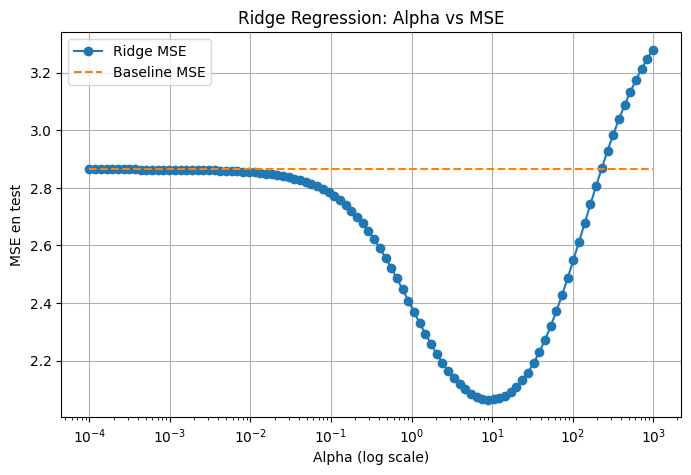

In [12]:
import matplotlib.pyplot as plt

# Graficar alpha vs error MSE en test
plt.figure(figsize=(8,5))
plt.plot(alphas, err_ridge, label="Ridge MSE", marker="o")
plt.plot(alphas, baseline, label="Baseline MSE", linestyle="--")

# Escala logarítmica en el eje X (porque alpha se generó en logspace)
plt.xscale("log")

plt.xlabel("Alpha (log scale)")
plt.ylabel("MSE en test")
plt.title("Ridge Regression: Alpha vs MSE")
plt.legend()
plt.grid(True)
plt.show()

### Ridge Regression: Alpha vs MSE

Este gráfico muestra cómo varía el **error cuadrático medio (MSE) en test** al cambiar el parámetro de regularización **α (alpha)** en una **regresión Ridge**.

- **Eje X (Alpha log scale):**  
  Representa los valores de α en escala logarítmica.  
  - Valores pequeños (≈ `10^-4`) se parecen a una regresión lineal sin regularización.  
  - Valores grandes (≈ `10^3`) implican una regularización muy fuerte, que puede empeorar el desempeño.

- **Eje Y (MSE en test):**  
  Indica el **error cuadrático medio** en el conjunto de prueba.  
  Un valor más bajo significa mejor rendimiento del modelo.

- **Curva azul (Ridge MSE):**  
  Muestra el MSE del modelo Ridge para distintos valores de α.  
  - El error disminuye al aumentar α hasta cierto punto (óptimo alrededor de `α ≈ 10`).  
  - Luego, el error vuelve a crecer cuando la regularización es excesiva.

- **Línea naranja discontinua (Baseline MSE):**  
  Es la referencia del MSE de un modelo base (ejemplo: regresión lineal sin regularización).  
  Sirve para comparar si la regresión Ridge realmente mejora el rendimiento.


**Conclusión:**  
Existe un valor óptimo de α (aprox. en torno a `10`) que **minimiza el error en test**. La regularización Ridge ayuda a mejorar el desempeño respecto al modelo base, evitando tanto el sobreajuste como el subajuste.

In [13]:
from sklearn.linear_model import Ridge 
  
# Train the model with alpha = 10 
ridgeR = Ridge(alpha = 10) 
ridgeR.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, ridgeR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, ridgeR.predict(X_test)))

Train MSE: 0.3160
Test MSE: 2.0651


* El valor óptimo del coeficiente de regularización $\lambda$ está alrededor de 10.
* Para $\lambda \to 0$ el término de regularización desaparece llevando al mismo resultado que la regresión lineal.
* Para $\lambda \to \infty$ la magnitud del término de regularización domina.

In [14]:
len(coef_ridge)

100

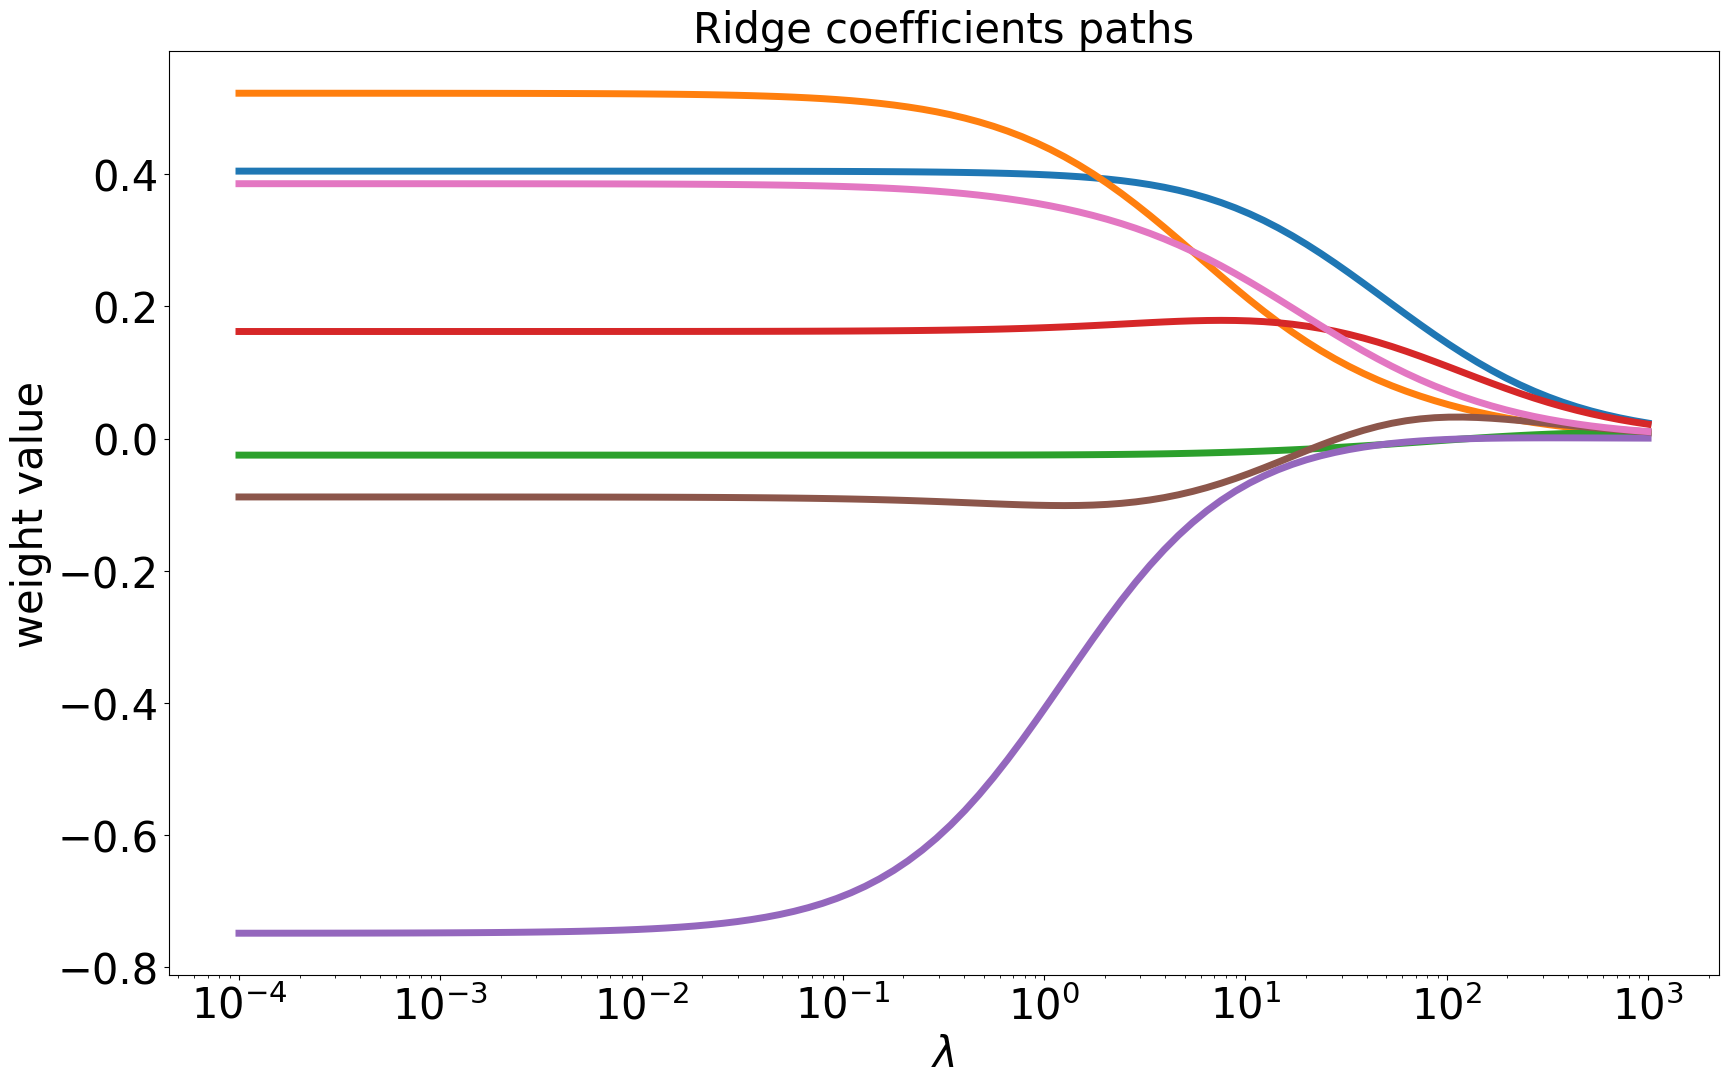

In [15]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_ridge, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Ridge coefficients paths', fontsize=30)
plt.show()

* La regresión Ridge restringe algunas variables reduciendo la magnitud de sus pesos.

## 2.2) Operador de Selección y Reducción Absoluta Mínima

El siguiente método va más allá al seleccionar algunas variables para ser eliminadas de la regresión Ridge, reduciendo así la dimensión.
El método se llama Operador de Selección y Reducción Absoluta Mínima (Lasso) y el modelo simplificado resultante es un **modelo disperso** o parsimonioso.
En Lasso, el término de regularización se define por $Reg(\beta) = ||\beta||_1$.

Lasso realiza una selección de características del modelo: para variables correlacionadas, retiene solo una variable y establece otras variables correlacionadas en cero.
La contrapartida es que obviamente induce una pérdida de información resultando en menor precisión.

In [16]:
from sklearn.linear_model import Lasso
from sklearn import metrics

# Creamos un modelo Lasso con alpha = 0.1 (fuerza de regularización)
# Lasso hace regresión lineal con penalización L1 (reduce algunos coeficientes a cero)
lassoR = Lasso(alpha=0.1)

# Entrenamos el modelo Lasso con los datos de entrenamiento
lassoR.fit(X_train, y_train)

# Evaluamos el modelo base (lr) que sería la regresión lineal sin regularización
print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)), 2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)), 2))

# Evaluamos el modelo Lasso con alpha=0.1
# MSE en entrenamiento
print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))

# MSE en prueba
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))


Train MSE sin regularización: 0.29
Test MSE sin regularización: 2.86
Train MSE: 0.3740
Test MSE: 2.0788


### Comparación de MSE: Regresión Lineal vs Lasso (α=0.1)

| Modelo                        | Train MSE | Test MSE |
|-------------------------------|-----------|----------|
| **Sin regularización (lr)**   | 0.29      | 2.86     |
| **Con Lasso (α=0.1)**         | 0.3740    | 2.0788   |



###  Interpretación
- El modelo **sin regularización** ajusta mejor al *train* (0.29), pero se dispara en *test* (2.86) → **sobreajuste**.  
- El modelo **con Lasso** sacrifica un poco de ajuste en *train* (0.3740), pero **mejora en test** (2.0788).  
- Conclusión: **Lasso generaliza mejor** al reducir el error en datos nuevos.  


In [17]:
from sklearn import linear_model
from sklearn import metrics

# Creamos un modelo Lasso inicial
# fit_intercept=False indica que no se añade un término independiente (bias) en la regresión
lasso = linear_model.Lasso(fit_intercept=False)

# Listas para guardar resultados
coef_lasso = []   # Aquí guardaremos los coeficientes del modelo para cada alpha
err_lasso = []    # Aquí guardaremos el MSE en test para cada alpha

# Recorremos cada valor de alpha
for a in alphas:
    # Establecemos el valor de alpha actual en el modelo
    lasso.set_params(alpha=a)
    
    # Entrenamos el modelo con los datos de entrenamiento
    lasso.fit(X_train, y_train)
    
    # Guardamos los coeficientes ajustados para este alpha
    coef_lasso.append(lasso.coef_)
    
    # Hacemos predicciones en el conjunto de prueba
    y_pred = lasso.predict(X_test)
    
    # Calculamos el error cuadrático medio en test
    lasso_error = metrics.mean_squared_error(y_pred, y_test)
    
    # Guardamos el error correspondiente a este alpha
    err_lasso.append(lasso_error)


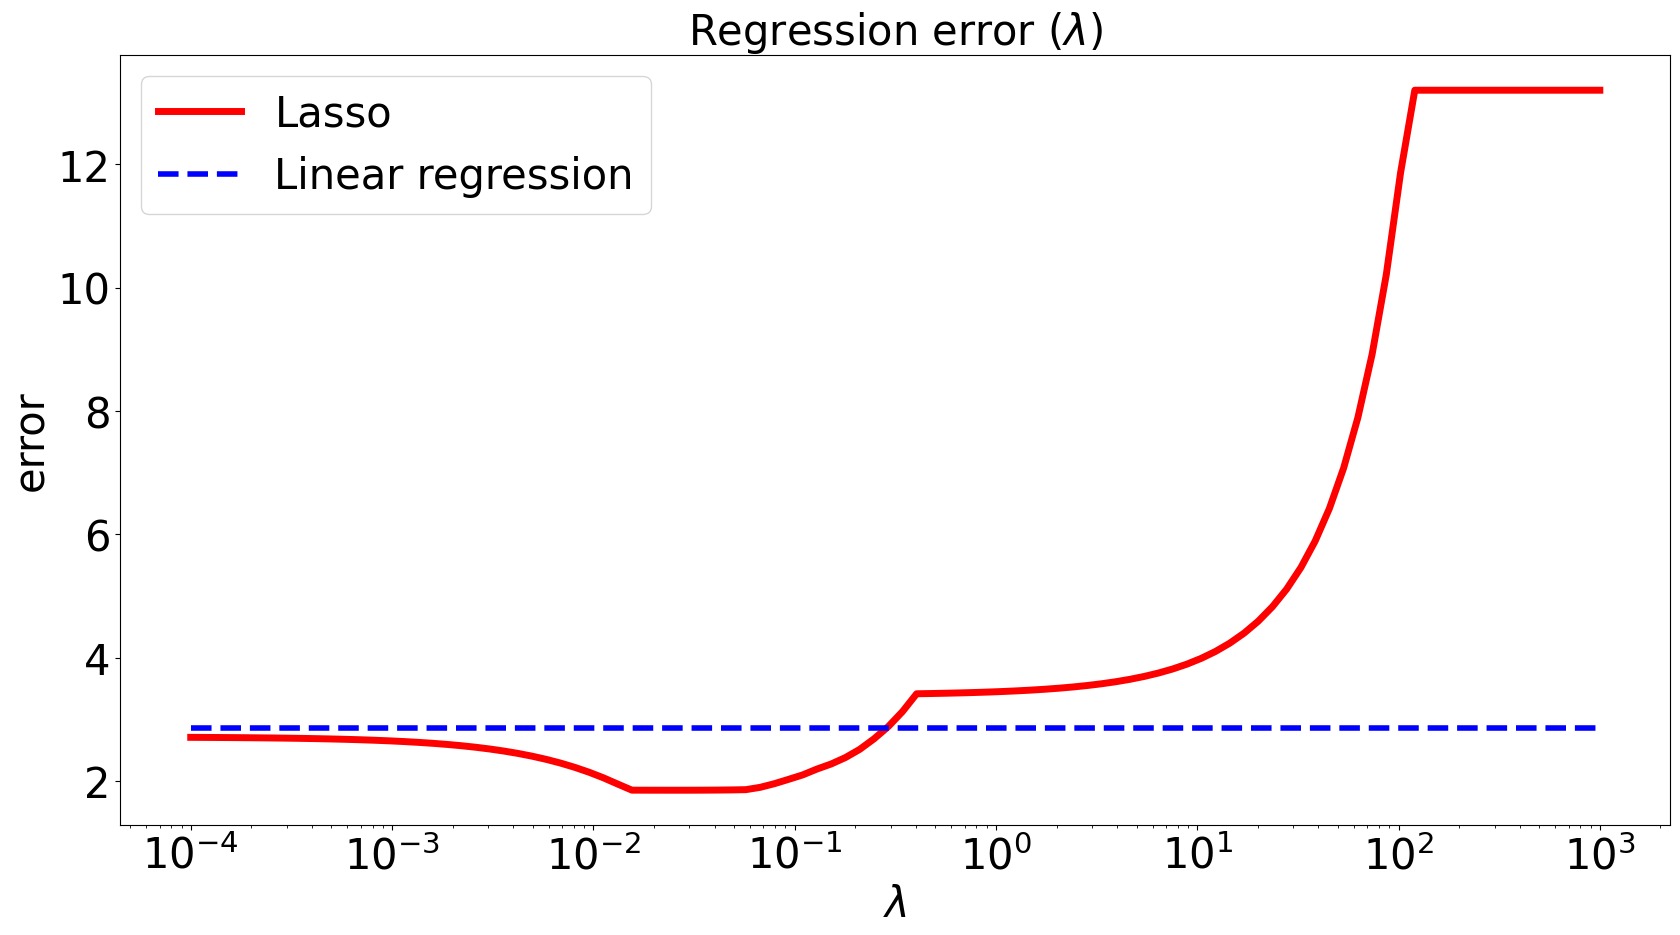

In [18]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [19]:
lassoR = Lasso(alpha = 0.02) 
lassoR.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

Train MSE: 0.3061
Test MSE: 1.8514


In [20]:
print("Test MAPE: %0.4f" % metrics.mean_absolute_percentage_error(y_test, lassoR.predict(X_test)))

Test MAPE: 0.3103


* El valor óptimo del coeficiente de regularización $\lambda$ está entre $10^{-2}$ y $10^{-1}$.
* Para $\lambda \to 0$ el término de regularización desaparece por lo que la regresión Lasso tiende a la regresión lineal.
* Para $\lambda \to \infty$ la magnitud del término de regularización domina el error.

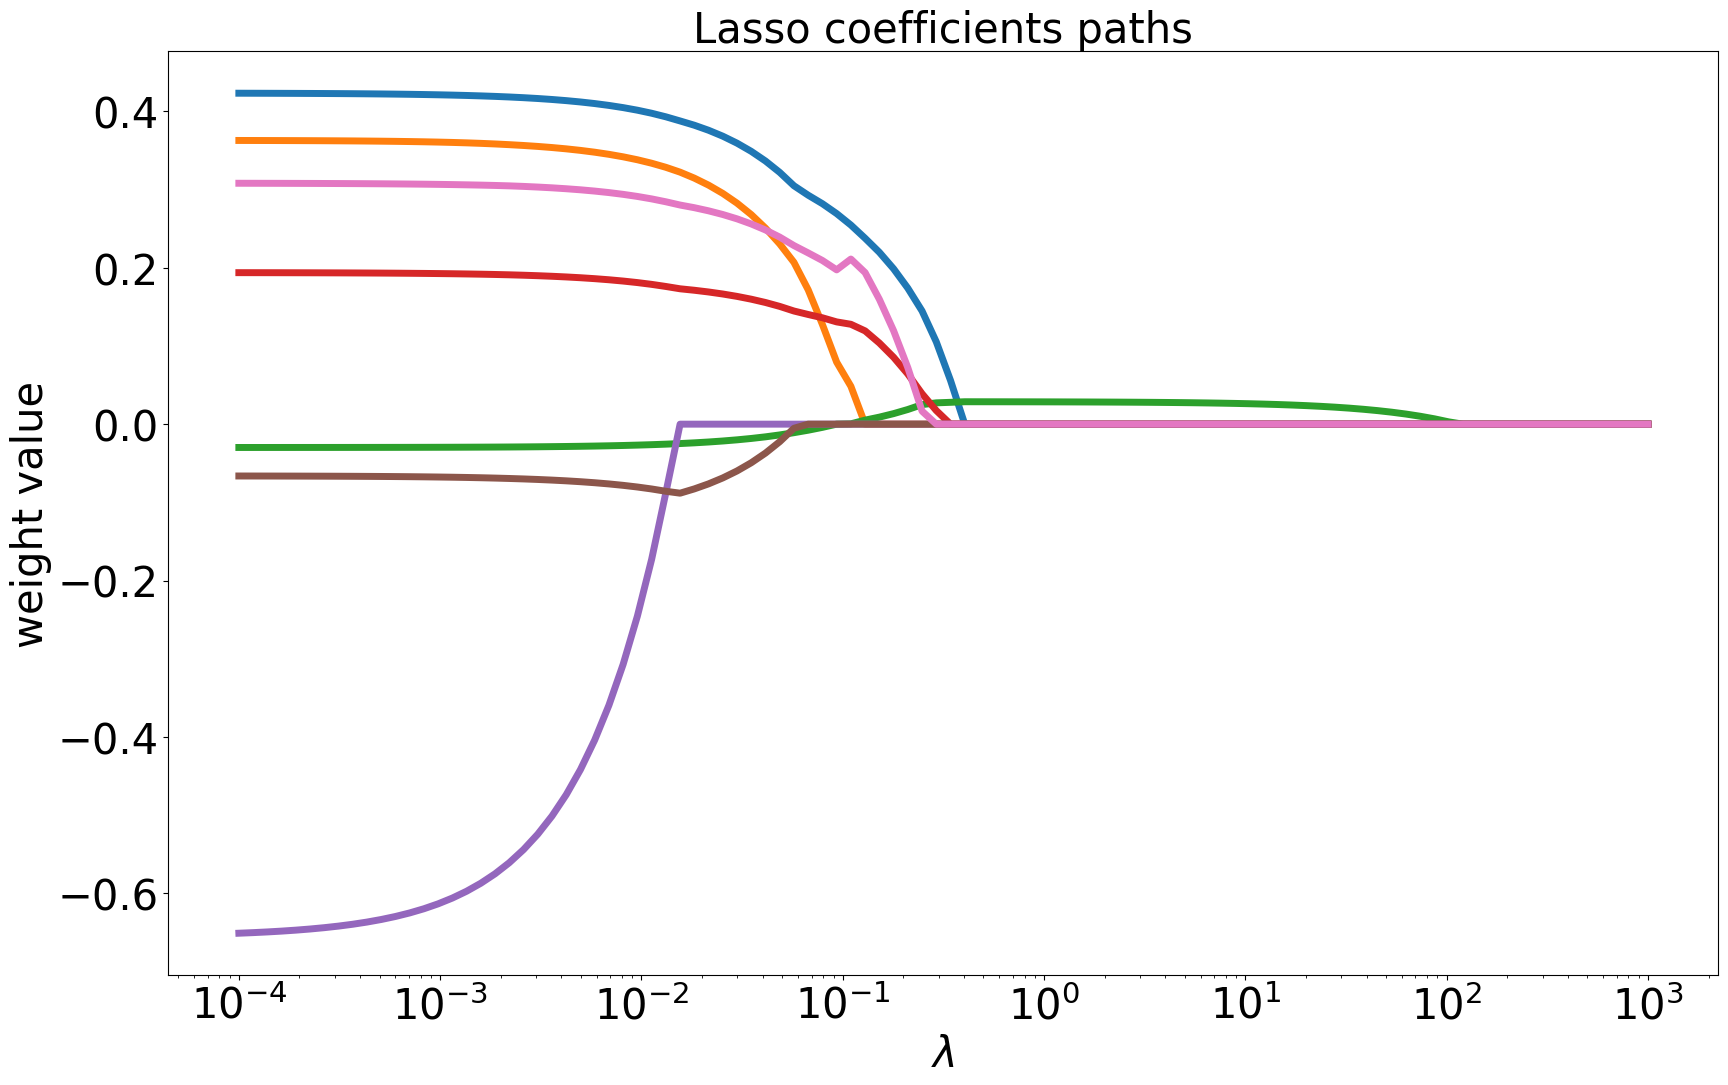

In [21]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_lasso, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Lasso coefficients paths', fontsize=30)
plt.show()

### Lasso Coefficients Paths

Este gráfico muestra cómo cambian los **coeficientes (pesos)** de las variables en un modelo de **regresión Lasso** cuando se varía la fuerza de la regularización (λ o alpha).

- **Eje X (λ en escala logarítmica):**  
  - Representa la intensidad de la regularización.  
  - Valores pequeños de λ → poca regularización (parecido a regresión lineal).  
  - Valores grandes de λ → mucha regularización (coeficientes se acercan a 0).

- **Eje Y (weight value):**  
  - Muestra el valor del coeficiente de cada variable.  
  - Cada línea de color corresponde a una variable distinta.

- **Curvas de colores:**  
  - Con poca regularización, los coeficientes tienen valores libres.  
  - A medida que λ aumenta, los coeficientes van disminuyendo hacia 0.  
  - Algunos coeficientes llegan exactamente a 0 → esas variables son eliminadas del modelo.  
  - Esto significa que **Lasso no solo regula la magnitud de los coeficientes, sino que también hace selección de variables**.



✅ **Conclusión:**  
El gráfico ilustra cómo **Lasso va “apagando” variables progresivamente** al aumentar la regularización, quedándose únicamente con las más importantes y simplificando el modelo.


* Lasso elimina algunas variables poniendo su peso en cero.<br>
  Este es el caso si dos variables están correlacionadas.
* Cuando $\lambda \to \infty$ los pesos desaparecen por lo que el modelo se vuelve muy **disperso**.

## 2.3) Elastic net

El método Elastic Net es un híbrido de la regresión Ridge y Lasso, superando así el problema de pérdida de información.
El término de regularización combina tanto las regularizaciones $L_1$ como $L_2$.
Más precisamente, el término de regularización se establece como $Reg(\beta) = \lambda((1-\alpha)||\beta||_1+\alpha||\beta||_2^2)$ donde $\alpha$ es un parámetro adicional a ajustar.

Elastic net tiene un efecto de selección en variables como Lasso pero mantiene variables correlacionadas como la regresión Ridge.
Así, el modelo Elastic net es menos disperso que Lasso, manteniendo más información. 
Sin embargo, el modelo es más exigente en recursos computacionales.

En lo que sigue presentamos resultados para $\alpha=0.5$.

In [22]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 1, l1_ratio = 0.5)
elastic_net.fit(X_train, y_train)

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))

Train MSE: 0.6375
Test MSE: 3.5183


In [23]:
np.random.randint(0,1,100)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [24]:
from sklearn.linear_model import ElasticNet
from sklearn import metrics

# Listas para guardar resultados
coef_eln = []     # Coeficientes del modelo para cada alpha
err_eln = []      # MSE en test para cada alpha
baseline = []     # Error base (para comparar con un modelo sencillo)

# Recorremos distintos valores de alpha
for a in alphas:
    # Creamos el modelo ElasticNet con el alpha actual
    # l1_ratio = 1 → equivale a Lasso (solo penalización L1)
    # (si l1_ratio estuviera entre 0 y 1, sería una mezcla de Ridge y Lasso)
    elastic_net = ElasticNet(alpha=a, l1_ratio=1)

    # Entrenamos el modelo con los datos de entrenamiento
    elastic_net.fit(X_train, y_train)

    # Guardamos los coeficientes para este alpha
    coef_eln.append(elastic_net.coef_)

    # Hacemos predicciones sobre el conjunto de prueba
    y_pred = elastic_net.predict(X_test)

    # Calculamos el error cuadrático medio (MSE) en test
    elasticnet_error = metrics.mean_squared_error(y_pred, y_test)
    err_eln.append(elasticnet_error)

    # Guardamos el error baseline (referencia) para este alpha
    baseline.append(baseline_error)


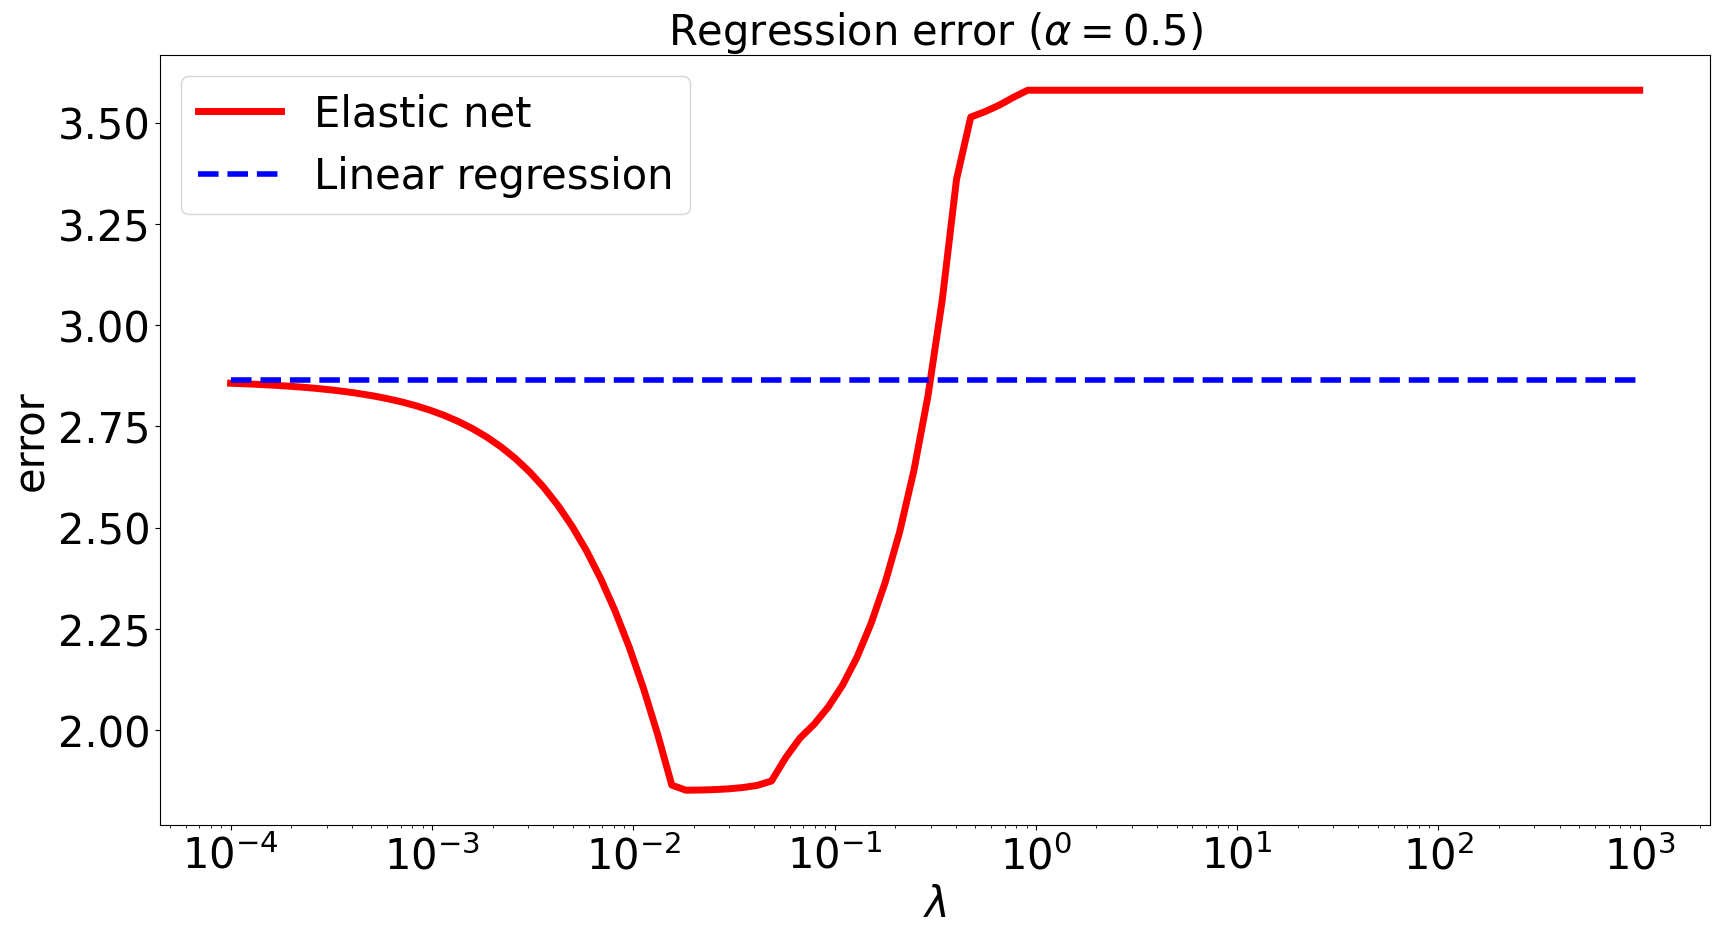

In [25]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_eln, linewidth=5, color='red', label="Elastic net")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\alpha=0.5$)', fontsize=30)
plt.show()

In [26]:
elastic_net = ElasticNet(alpha = 0.02, l1_ratio=1)
elastic_net.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))

Train MSE: 0.3061
Test MSE: 1.8514


* El valor óptimo del coeficiente de regularización $\lambda$ está entre $10^{-2}$ y $10^{-1}$.
* Para $\lambda \to 0$ el término de regularización desaparece llevando al mismo resultado que la regresión lineal.
* Para $\lambda \to \infty$ la magnitud del término de regularización domina el error que es menor que con Lasso.

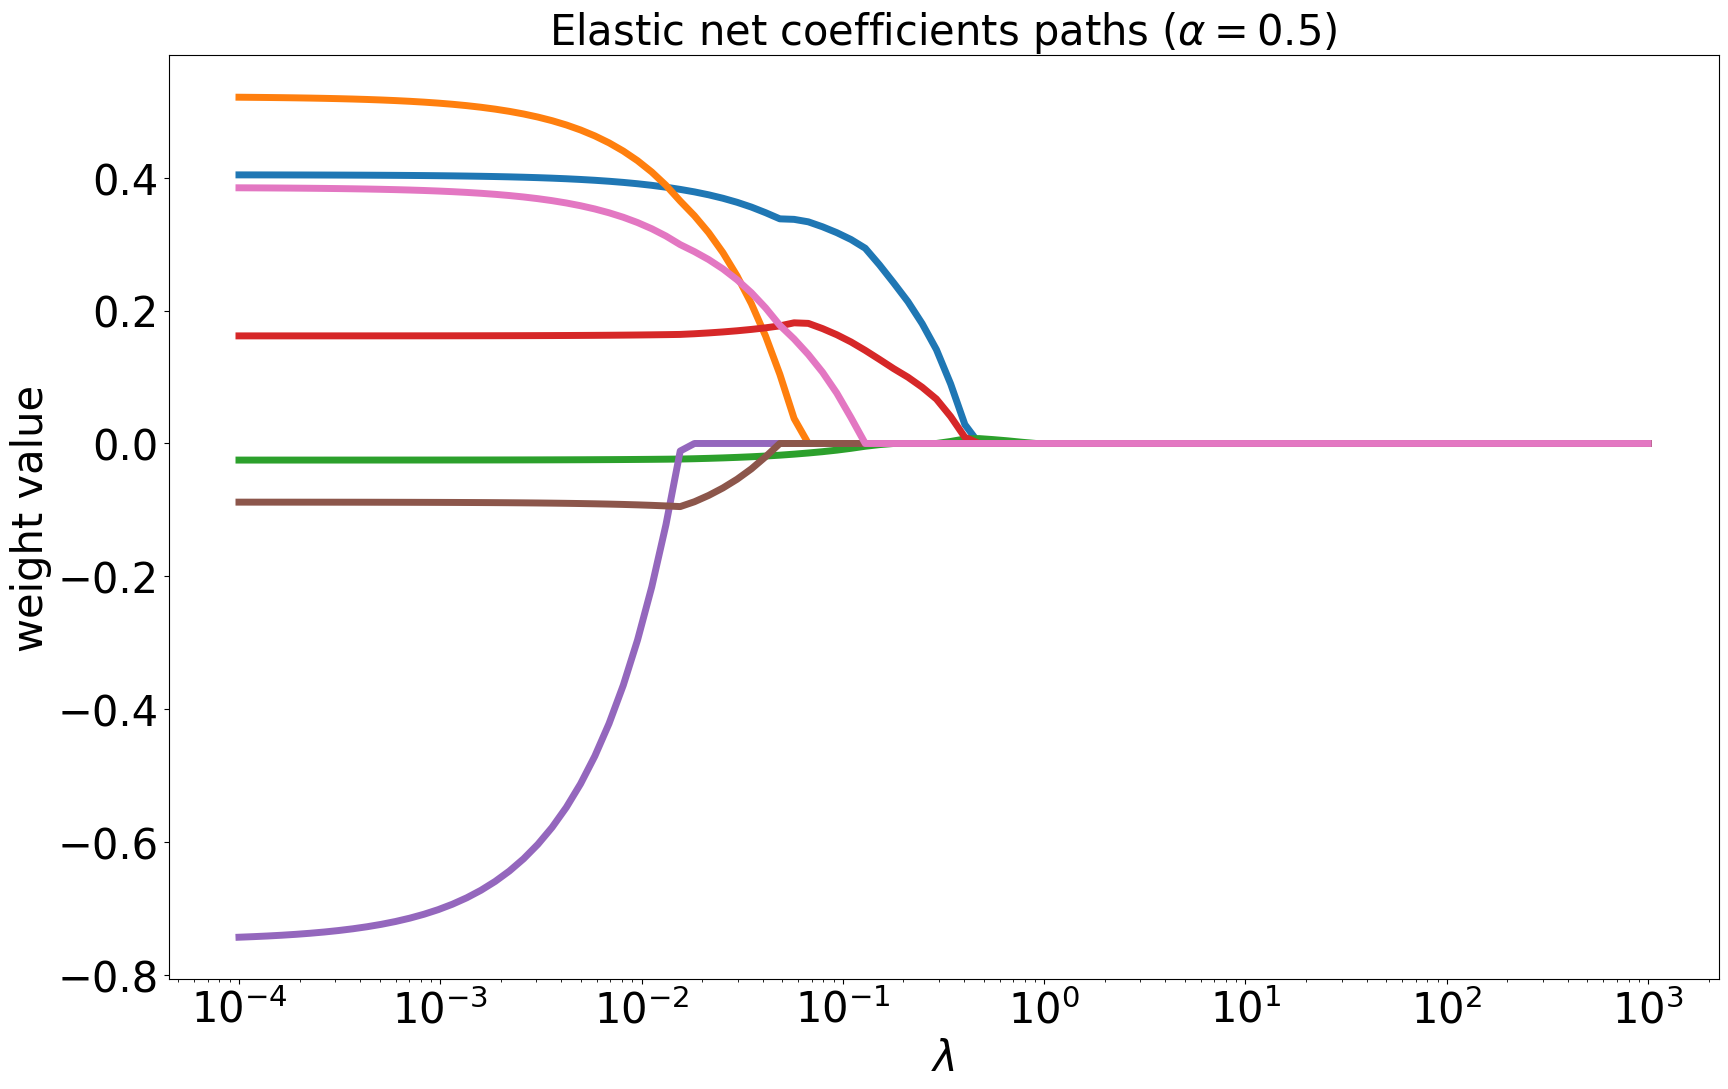

In [27]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_eln, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title(r'Elastic net coefficients paths ($\alpha=0.5$)', fontsize=30)
plt.show()

* Como se esperaba, Elastic net mantiene más variables que Lasso.
* Se puede obtener un mejor rendimiento variando el valor del hiperparámetro $\alpha$.

<br>

# Selección de modelo 

In [28]:
print("Linear regression error:   %0.4f" % baseline_error)
print("Minimun ridge error:       %0.4f" % min(err_ridge))
print("Minimum lasso error:       %0.4f" % min(err_lasso))
print("Minimum elastic net error: %0.4f" % min(err_eln))

Linear regression error:   2.8641
Minimun ridge error:       2.0651
Minimum lasso error:       1.8531
Minimum elastic net error: 1.8512


* Lasso funciona mejor que otros métodos (Elastic net: $\alpha=0.5$). 
* Lasso es más parsimonioso pero es probable que haya una pérdida de precisión.
* Elastic net funciona mejor que la regresión Ridge (con $\alpha=0.5$).
* Elastic net se puede ajustar para superar a Lasso pero es más exigente en recursos computacionales.

**=> Elastic net es un buen equilibrio para el balance entre precisión y costo computacional entre la regresión Ridge y Lasso**.

Para optimizar el modelo ajustando los parámetros óptimos, se puede realizar una validación cruzada.
Las funciones sklearn.linear_model.RidgeCV, sklearn.linear_model.LassoCV y sklearn.linear_model.ElasticNetCV en Python realizan un ajuste automático de hiperparámetros para la regresión Ridge, Lasso y Elastic Net respectivamente.